In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sympy import Symbol, diff, lambdify
from sklearn.linear_model import LinearRegression
from copy import deepcopy

# Plot settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 1

# Define SDE's

In [2]:
class SDE(ABC):
    def __init__(self, time_horizon, num_steps, x0):
        # time discretization
        self.T = time_horizon
        self.N = num_steps
        self.dt = time_horizon / num_steps
        self.ts = np.linspace(0, time_horizon, num_steps)

        # initial value
        self.x0 = x0

    @abstractmethod
    def drift(self, X_t, t):
        """
        Abstract method for drift coefficient
        :param X_t: float: current value of the process
        :param t: float: current time
        :return: float: drift coefficient
        """
        pass

    @abstractmethod
    def diffusion(self, X_t, t):
        """
        Abstract method for diffusion coefficient
        :param X_t: float: current value of the process
        :param t: float: current time
        :return: float: diffusion coefficient
        """
        pass

    @abstractmethod
    def exact_solution(self, W: np.ndarray):
        """
        Sample exact solution paths of the SDE
        :param W: np.ndarray: brownian motion to simulate SDE
        :return: torch.Tensor: Paths of shape (num_timesteps) if num_simulations=1 or (num_timesteps, num_simulations) otherwise
        """
        pass

    def sample_brownian_motion(self, seed=None):
        """
        Sample random Brownian Motion with given time discretization
        :param seed: int: seed to get control over sampled BB
        :return: np.ndarray: BB paths of shape (num_timesteps)
        """
        if seed is not None:
            np.random.seed(seed)
        dW = np.sqrt(self.dt) * np.random.randn(self.N)
        dW[0] = 0
        W = np.cumsum(dW)
        return W

    def update_time_discretization(self, num_steps=None, dt=None, ts=None):
        """
        Update time discretization of SDE instance. Only one of num_steps, dt or ts must be specified.
        :param num_steps: int: number of time steps
        :param dt: float: time step
        :param ts: np.ndarray: time grid
        """
        if num_steps is not None:
            self.N = num_steps
            self.dt = self.T / num_steps
            self.ts = np.linspace(0, self.T, num_steps)
        elif dt is not None:
            self.dt = dt
            self.N = int(self.T / dt)
            self.ts = np.linspace(0, self.T, self.N)
        elif ts is not None:
            self.ts = ts
            self.N = len(ts)
            self.dt = ts[1] - ts[0]
        else:
            raise ValueError("Either num_steps, dt or ts must be specified")

    def __repr__(self):
        """
        String representation of SDE instance
        """
        return f"{type(self).__name__}(time_horizon={self.T}, num_steps={self.N}, x0={self.x0})"

In [3]:
T = 1  # time horizon
X0 = 1  # initial value
NUM_STEPS = 1000  # number of discretization steps
SEED = 7  # random seed

### Geometric Brownian Motion

In [4]:
class GeometricBrownianMotion(SDE):
    def __init__(self, time_horizon, num_steps, x0, mu, sigma):
        super().__init__(time_horizon, num_steps, x0)
        self.mu = mu
        self.sigma = sigma

    def drift(self, X_t, t):
        return self.mu * X_t

    def diffusion(self, X_t, t):
        return self.sigma * X_t

    def exact_solution(self, W: np.ndarray) -> np.ndarray:
        X = self.x0 * np.exp((self.mu - 0.5 * self.sigma ** 2) * self.ts + self.sigma * W)
        return X

    def __repr__(self):
        return f"Geometric Brownian Motion with T={self.T}, N={self.N}, x0={self.x0}, mu={self.mu}, sigma={self.sigma}"

### Ornstein-Uhlenbeck

In [5]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self, time_horizon, num_steps, x0, mu, theta, sigma):
        super().__init__(time_horizon, num_steps, x0)
        assert sigma > 0, "Assumptions on SDE parameters are not satisfied"  # should theta also be positive here?
        self.mu = mu
        self.theta = theta
        self.sigma = sigma

    def drift(self, X_t, t):
        return self.theta * (self.mu - X_t)

    def diffusion(self, X_t, t):
        return self.sigma

    def exact_solution(self, W: np.ndarray):
        dW = np.diff(W)
        int_terms = np.zeros(self.N)
        for i in range(1, self.N):
            int_terms[i] = np.sum(np.exp(-self.theta * (self.ts[i] - self.ts[:i])) * dW[:i])
        X = self.x0 * np.exp(-self.theta * self.ts) + self.mu * (1 - np.exp(-self.theta * self.ts)) + self.sigma * int_terms
        return X

    def __repr__(self):
        return f"Ornstein Uhlenbeck Process with T={self.T}, N={self.N}, x0={self.x0}, mu={self.mu}, theta={self.theta}, sigma={self.sigma}"

### Cox-Ingersoll-Ross

In [6]:
class CoxIngersollRoss(SDE):
    def __init__(self, time_horizon, num_steps, x0, a, b, sigma):
        super().__init__(time_horizon, num_steps, x0)
        assert a >= 0 and b >= 0 and sigma > 0, "Assumptions on SDE parameters are not satisfied"
        self.a = a
        self.b = b
        self.sigma = sigma
        self.delta = 4 * self.a / (self.sigma ** 2)

    def drift(self, X_t, t):
        return self.a - self.b * X_t

    def diffusion(self, X_t, t):
        if self.delta < 2:
            X_t = np.abs(X_t)
        else:
            X_t = np.maximum(X_t, 1e-9)
        return self.sigma * (X_t ** 0.5)

    def exact_solution(self, W: np.ndarray):
        if self.a == 1 and self.sigma == 2:
            """
            dX_t = (1 - bX_t) dt + 2 sqrt(X_t) dW_t
            https://arxiv.org/pdf/1601.01455.pdf (Proposition 1)
            """
            U = OrnsteinUhlenbeck(self.T, self.N, np.sqrt(self.x0), mu=0, theta=self.b/2, sigma=1).exact_solution(W)
            inf_inputs = [np.exp(self.b * self.ts[i] / 2) * U[i] for i in range(self.N)]
            X = np.zeros(self.N)
            X[0] = self.x0
            for i in range(self.N-1):
                X[i+1] = (U[i+1] + np.exp(-self.b * self.ts[i] / 2) * (-np.minimum(0, np.min(inf_inputs[:i+1])))) ** 2
        else:
            raise NotImplementedError("Exact solution is not implemented or not known")
        return X

    def __repr__(self):
        return f"Cox-Ingersoll-Ross Process with T={self.T}, N={self.N}, x0={self.x0}, a={self.a}, b={self.b}, sigma={self.sigma}"

## Choose sde

Choose SDE between one of implemented above

In [7]:
# sde = GeometricBrownianMotion(time_horizon=T, num_steps=NUM_STEPS, x0=X0, mu=2, sigma=1)
sde = CoxIngersollRoss(time_horizon=T, num_steps=NUM_STEPS, x0=X0, a=1, b=0, sigma=2)
# sde = OrnsteinUhlenbeck(time_horizon=T, num_steps=NUM_STEPS, x0=X0, mu=0, theta=1, sigma=1)

print(f'Chosen SDE: {sde}')

Chosen SDE: Cox-Ingersoll-Ross Process with T=1, N=1000, x0=1, a=1, b=0, sigma=2


## Examples of exact solutions


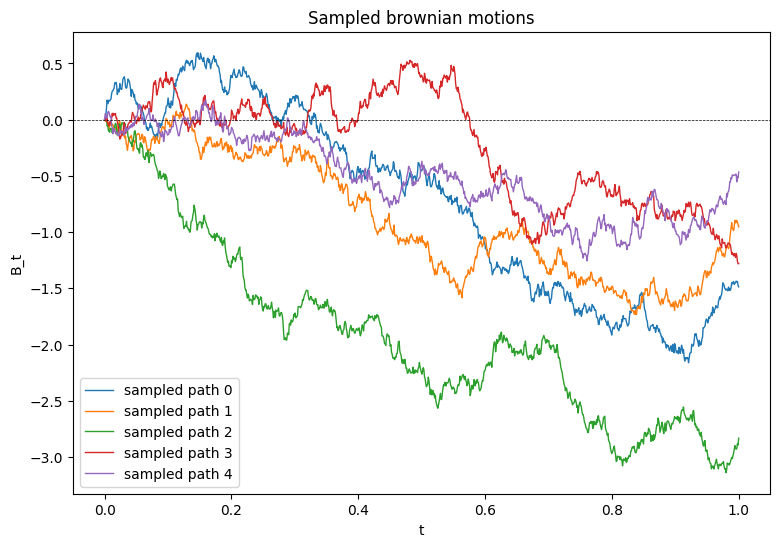

In [8]:
num_simulations = 5

for num in range(num_simulations):
    brownian_motion = sde.sample_brownian_motion(seed=SEED * num)
    plt.plot(sde.ts, brownian_motion, label = "sampled path " + str(num))

plt.title(f'Sampled brownian motions')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5)
plt.ylabel('B_t')
plt.xlabel('t')
plt.legend()

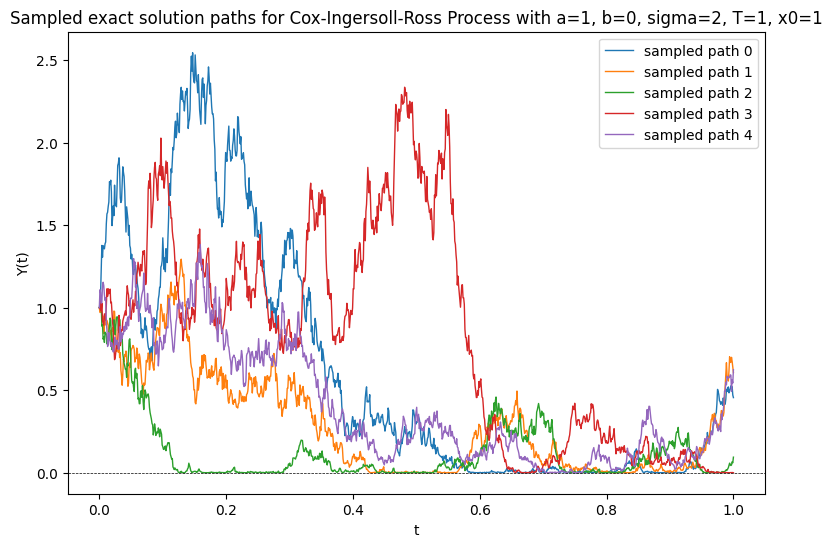

In [9]:
num_simulations = 5

for num in range(num_simulations):
    brownian_motion = sde.sample_brownian_motion(seed=SEED * num)
    exact_solution = sde.exact_solution(brownian_motion)
    plt.plot(sde.ts, exact_solution, label = "sampled path " + str(num))

plt.title(f'Sampled exact solution paths for Cox-Ingersoll-Ross Process with a={sde.a}, b={sde.b}, sigma={sde.sigma}, T={sde.T}, x0={sde.x0}')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5)
plt.ylabel('Y(t)')
plt.xlabel('t')
plt.legend()

### Distribution of exact solutions of Geometric Brownian Motion with different parameters

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


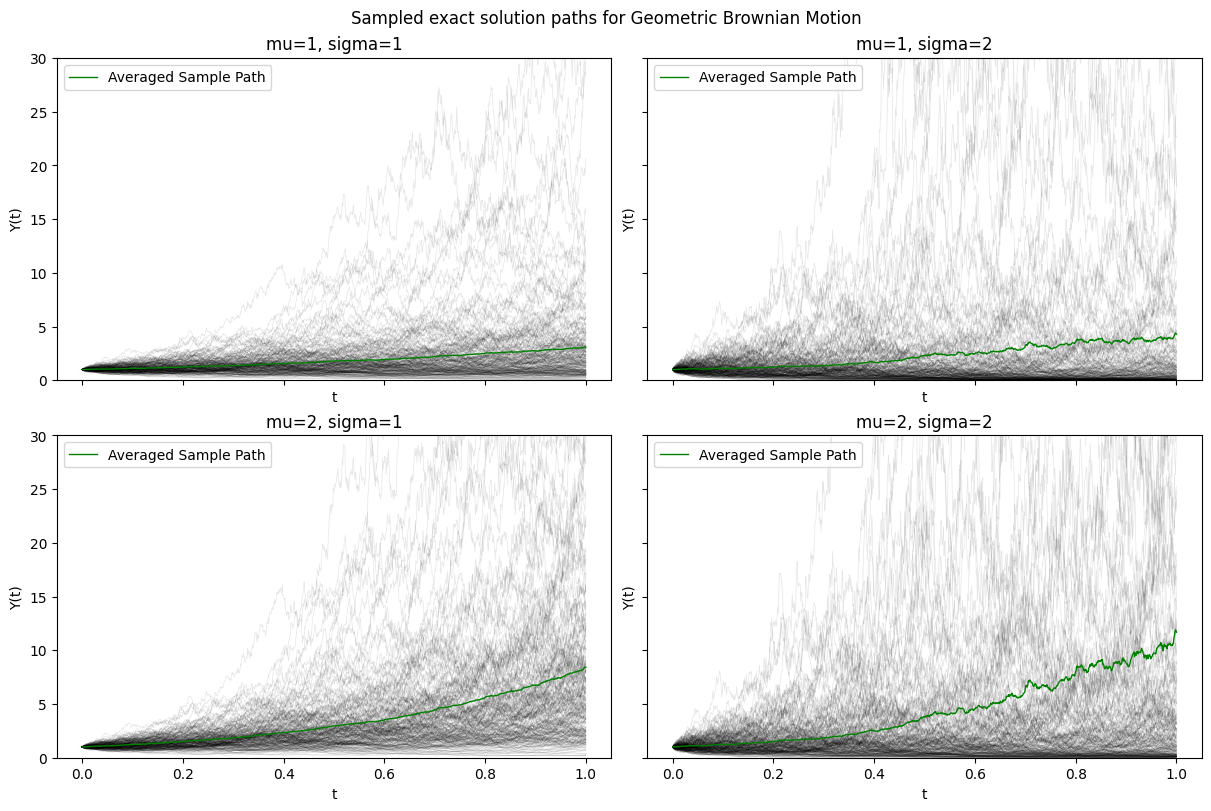

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Sampled exact solution paths for Geometric Brownian Motion')

num_simulations = 250
ylim = 30

# Exact Solutions for different parameters
mus = [1, 2]
sigmas = [1, 2]
for i in range(len(mus)):
    for j in range(len(sigmas)):
        gbm = GeometricBrownianMotion(time_horizon=T, num_steps=1000, x0=X0, mu=mus[i], sigma=sigmas[j])
        mean_path = np.zeros(gbm.N)
        for num in range(num_simulations):
            brownian_motion = gbm.sample_brownian_motion(seed=SEED * num)
            exact_solution = gbm.exact_solution(brownian_motion)
            mean_path += exact_solution
            axs[i, j].plot(gbm.ts, exact_solution, alpha=0.1, color='black', linewidth=0.5)
        axs[i, j].plot(gbm.ts, mean_path / num_simulations, label="Averaged Sample Path", color='green')
        axs[i, j].set_title(f'mu={mus[i]}, sigma={sigmas[j]}')
        axs[i, j].set_ylabel('Y(t)')
        axs[i, j].set_xlabel('t')
        axs[i, j].set_ylim(0, ylim)
        axs[i, j].legend()

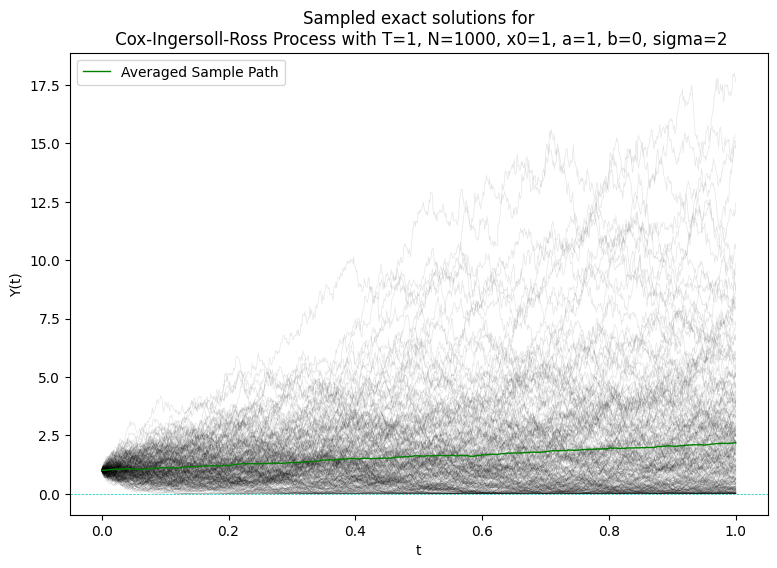

In [11]:
num_simulations = 250

# Exact Solutions
mean_path = np.zeros(sde.N)
for num in range(num_simulations):
    brownian_motion = sde.sample_brownian_motion(seed=SEED * num)
    exact_solution = sde.exact_solution(brownian_motion)
    mean_path += exact_solution
    plt.plot(sde.ts, exact_solution, alpha=0.1, color='black', linewidth=0.5)
plt.plot(sde.ts, mean_path / num_simulations, label="Averaged Sample Path", color='green')
plt.axhline(y = 0, color = 'c', linestyle = '--', linewidth = 0.5)
plt.title(f'Sampled exact solutions for\n {sde}')
plt.ylabel('Y(t)')
plt.xlabel('t')
plt.legend()

## Solution approximations

We define several approximation methods for SDEs. We will use them to approximate exact solutions of SDEs and calculate convergence rates.

In [12]:
APPROXIMATION_METHODS = [
    'Euler-Maruyama',
    'Milstein',
    # 'Runge-Kutta'
]  # list of methods to use

def euler_maruyama(sde: SDE, W: np.ndarray):
    dW = np.diff(W)
    X = np.zeros(sde.N)
    X[0] = sde.x0
    for i in range(sde.N - 1):
        X[i+1] = X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
    return X

def milstein(sde: SDE, W: np.ndarray):
    assert all(sde.diffusion(sde.x0, 0) == sde.diffusion(sde.x0, t) for t in sde.ts), "Milstein method requires diffusion to be independent of time"

    dW = np.diff(W)
    X = np.zeros(sde.N)
    X[0] = sde.x0

    if isinstance(sde, CoxIngersollRoss):
        for i in range(sde.N - 1):
            X[i+1] = (X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
                    + 0.25 * sde.sigma ** 2 * (dW[i] ** 2 - sde.dt))
    else:
        # symbolic differentiation of diffusion function
        x = Symbol('X')
        diffusion_derivative = lambdify(x, diff(sde.diffusion(x, t=0), x), 'numpy')
        for i in range(sde.N - 1):
            X[i+1] = (X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
                    + 0.5 * sde.diffusion(X[i], sde.ts[i]) * diffusion_derivative(X[i]) * (dW[i] ** 2 - sde.dt))

    return X

def runge_kutta(sde: SDE, W: np.ndarray):
    assert all(sde.drift(sde.x0, 0) == sde.drift(sde.x0, t) for t in sde.ts), "Runge-Kutta method requires drift to be independent of time"
    assert all(sde.diffusion(sde.x0, 0) == sde.diffusion(sde.x0, t) for t in sde.ts), "Runge-Kutta method requires diffusion to be independent of time"

    dW = np.diff(W)
    X = np.zeros(sde.N)
    X[0] = sde.x0
    for i in range(0, sde.N-1):
        a = sde.drift(X[i], 0)
        b = sde.diffusion(X[i], 0)
        korr_X = X[i] + a * sde.dt + b * sde.dt ** 0.5
        X[i+1] = X[i] + a * sde.dt + b * dW[i] + 0.5 * (sde.diffusion(korr_X, 0) - b) * (dW[i] ** 2 - sde.dt) * (sde.dt ** -0.5)
    return X

def approximation_method(name: str):
    """
    Get approximation method by name
    :param name: str: name of approximation method
    :return: function: approximation method
    """
    if name == 'Euler-Maruyama':
        return euler_maruyama
    elif name == 'Milstein':
        return milstein
    elif name == 'Runge-Kutta':
        return runge_kutta
    else:
        raise NotImplementedError(f'Approximation method {name} not implemented')

Let's compare exact solution and implemented approximations. Beware, randomness of sampled path is always hidden inside used sampled BB path. So two sampled paths are comparable only if they are based on same BB.
Time discretization resolution should probably be lower to see difference.

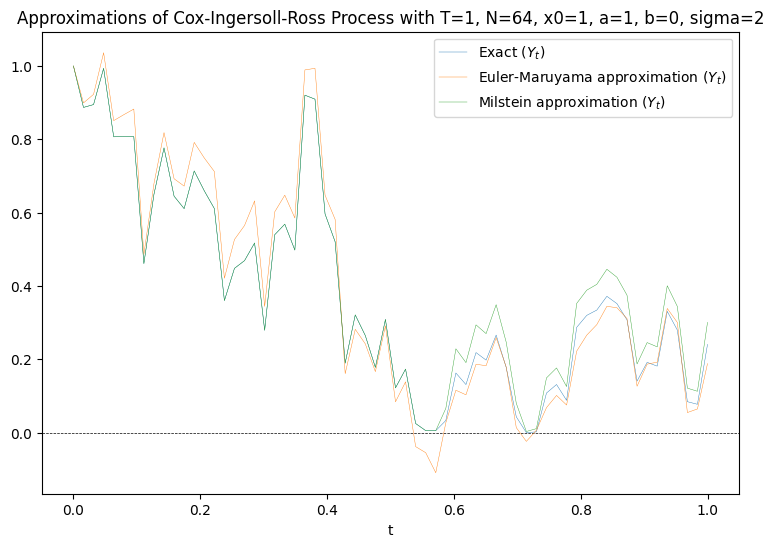

In [13]:
sde.update_time_discretization(num_steps=64)
brownian_motion = sde.sample_brownian_motion(seed=SEED)

# Exact solution
exact_solution = sde.exact_solution(brownian_motion)
plt.plot(sde.ts, exact_solution, label="Exact ($Y_t$)", linewidth=0.3)
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5)

# Approximations
for method_name in APPROXIMATION_METHODS:
    approximation = approximation_method(method_name)(sde, brownian_motion)
    plt.plot(sde.ts, approximation, label=f"{method_name} approximation ($Y_t$)", linewidth=0.3)
    plt.title(f'Approximations of {sde}')
plt.xlabel('t')
plt.legend()

## $L^p$ errors

Now we calculate $L^p$ error for sampled solution and approximation paths.
Mathematically, strong $L^p$ error between two processes $X$ and $Y$ is defined as
$$ e(X, Y) = \sup_{t \in [0, T]} \mathbb{E} \Big[ \left| X_t - Y_t \right|^p \Big]^{1/p}\,, $$
for finite time discretization with N timesteps we use
$$ e_N(X, Y) = \max_{t \in \{t_0, t_1, \dots, t_N\}} \mathbb{E} \Big[ \left| X_t - Y_t \right|^p \Big]^{1/p}\,. $$

With Monte Carlo simulation we approximate error between exact solution $X$ and approximation $\hat{X}$ as
$$ Err_N(X) = \max_{t \in \{t_0, t_1, \dots, t_N\}} \left[ \frac{1}{M}\sum_{i=1}^M \left| X^i_t - \hat{X}^i_t \right|^p \right]^{1/p}\,, $$
where $M$ is number of simulations and $X^i$, $\hat{X}^i$ are sampled paths (based on same BB) of exact solution and approximation respectively.

In [14]:
def calculate_error(solutions, calc_approximations, p=1):
    assert p >= 1, "p \in [1, \infty)"
    error = np.max(np.mean(np.abs(solutions - calc_approximations) ** p, axis=0) ** (1/p))
    return error

Errors: {'Euler-Maruyama': 0.04225176004104728, 'Milstein': 0.022937437423866756}


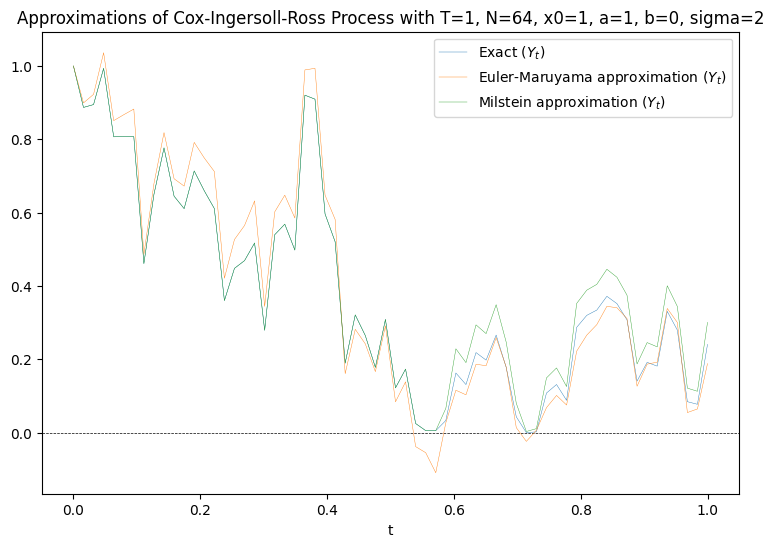

In [15]:
sde.update_time_discretization(num_steps=64)
brownian_motion = sde.sample_brownian_motion(seed=SEED)

# Exact solution
exact_solution = sde.exact_solution(brownian_motion)
plt.plot(sde.ts, exact_solution, label="Exact ($Y_t$)", linewidth=0.3)
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5)

# Approximations
errors = {}
for method_name in APPROXIMATION_METHODS:
    approximation = approximation_method(method_name)(sde, brownian_motion)
    errors[method_name] = calculate_error(exact_solution.reshape(-1, 1), approximation.reshape(-1, 1))
    plt.plot(sde.ts, approximation, label=f"{method_name} approximation ($Y_t$)", linewidth=0.3)
    plt.title(f'Approximations of {sde}')
plt.xlabel('t')
plt.legend()
print(f'Errors: {errors}')

In [16]:
# Initiate experiment parameters
p_values = (1, 2)  # p in L^p norm
dt_grid = [2 ** R for R in range(-8, -3)]
num_simulations = 10000

### Calculate errors using exact solutions

SDE is Cox-Ingersoll-Ross Process with T=1, N in [256, 128, 64, 32, 16], x0=1, a=1, b=0, sigma=2
Running simulations for N = 256
Running simulations for N = 128
Running simulations for N = 64
Running simulations for N = 32
Running simulations for N = 16
Done
CPU times: user 6min 48s, sys: 1.56 s, total: 6min 49s
Wall time: 7min 45s


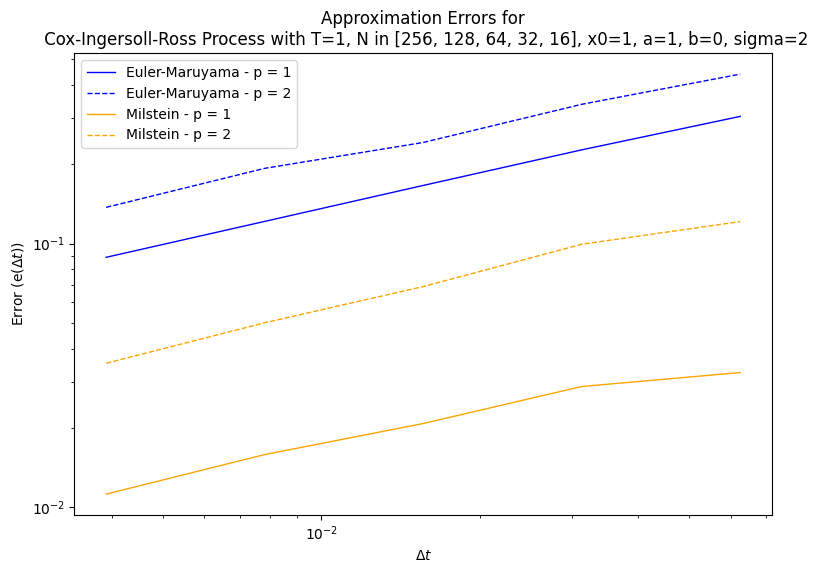

In [17]:
%%time

def calculate_errors_for_dt_grid(sde, dt_grid, num_simulations, p_values, visualize=True):
    errors = {(method_name, p): [] for method_name in APPROXIMATION_METHODS for p in p_values}
    num_steps_grid = [int(sde.T / dt) for dt in dt_grid]
    adapted_sde_name = str(sde).replace(f"N={sde.N}", f"N in {num_steps_grid}")
    print(f'SDE is {adapted_sde_name}')

    for N in num_steps_grid:
        print(f"Running simulations for N = {N}")
        # Initiate SDE
        sde.update_time_discretization(num_steps=N)
        exact_solutions = np.zeros((num_simulations, sde.N))
        approximations = {
            method_name: np.zeros((num_simulations, sde.N))
            for method_name in APPROXIMATION_METHODS
        }

        for num in range(num_simulations):
            # Generate sample path
            brownian_motion = sde.sample_brownian_motion(seed=SEED * num)

            # Calculate exact solution
            exact_solutions[num] = sde.exact_solution(brownian_motion)

            # Calculate approximations
            for method_name in APPROXIMATION_METHODS:
                approximations[method_name][num] = approximation_method(method_name)(sde, brownian_motion)

        # Calculate errors
        for p in p_values:
            for method_name in APPROXIMATION_METHODS:
                errors[(method_name, p)].append(
                    calculate_error(exact_solutions, approximations[method_name], p=p)
                )
    print("Done")

    # Plot
    if visualize:
        colors = ['blue', 'orange', 'green']
        for i, method_name in enumerate(APPROXIMATION_METHODS):
            plt.loglog(dt_grid, errors[(method_name, p_values[0])], label=f"{method_name} - p = {p_values[0]}", color=colors[i])
            plt.loglog(dt_grid, errors[(method_name, p_values[1])], label=f"{method_name} - p = {p_values[1]}", ls="--", color=colors[i])
        plt.title(f'Approximation Errors for\n {adapted_sde_name}')
        plt.xlabel('$\Delta t$')
        plt.ylabel('Error (e($\Delta t$))')
        plt.legend()

    return errors

errors_exact = calculate_errors_for_dt_grid(sde, dt_grid, num_simulations, p_values, visualize=True)

### Calculate errors using pseudo exact solutions

We can also use approximations with high discretization to calculate errors. We call them pseudo exact solutions.
Let $X_t^N$ be approximation with $N$ steps and $X_t^{2N}$ be approximation with $2N$ steps.
We assume approximation with $2N$ steps to be close enough to exact solution, and therefore we calculate error as
$$ Err(\Delta t) = \max_{t \in \{t_0, t_1, \dots, t_N\}} \mathbb{E} \Big[ \left| X_t^N - X_{2t}^{2N} \right|^p \Big]^{1/p} \,, $$

In [ ]:
%%time

def calculate_errors_for_dt_grid_with_pseudo_solutions(sde, dt_grid, num_simulations, p_values, visualize=False):
    errors = {(method_name, p): [] for method_name in APPROXIMATION_METHODS for p in p_values}
    num_steps_grid = [int(sde.T / dt) for dt in dt_grid]
    adapted_sde_name = str(sde).replace(f"N={sde.N}", f"N in {num_steps_grid}")
    print(f'SDE is {adapted_sde_name}')

    # pseudo exact solution for max(N)
    N_max = 2 * max(num_steps_grid)

    approximations = {
        (method_name, N): np.zeros((num_simulations, N))
        for method_name in APPROXIMATION_METHODS for N in [N_max] + num_steps_grid
    }

    sde.update_time_discretization(num_steps=N_max)
    brownian_motions = [sde.sample_brownian_motion(seed=SEED * num) for num in range(num_simulations)]

    for N in [N_max] + num_steps_grid:
        print(f"Running simulations for N = {N}")
        # update N
        sde.update_time_discretization(num_steps=N)

        for num in range(num_simulations):
            reduced_brownian_motion = brownian_motions[num][::N_max // N]
            # Generate sample path
            for method_name in APPROXIMATION_METHODS:
                # Calculate approximations
                approximations[(method_name, N)][num] = approximation_method(method_name)(sde, reduced_brownian_motion)

    # Calculate errors
    for N in num_steps_grid:
        for method_name in APPROXIMATION_METHODS:
            pseudo_exact_solution = approximations[(method_name, 2 * N)][:, ::2]
            approximation = approximations[(method_name, N)]
            for p in p_values:
                errors[(method_name, p)].append(
                    calculate_error(pseudo_exact_solution, approximation, p=p)
                )
    print("Done")

    # Plot
    if visualize:
        colors = ['blue', 'orange', 'green']
        for i, method_name in enumerate(APPROXIMATION_METHODS):
            plt.loglog(dt_grid, errors[(method_name, p_values[0])], label=f"{method_name} - p = {p_values[0]}", color=colors[i])
            plt.loglog(dt_grid, errors[(method_name, p_values[1])], label=f"{method_name} - p = {p_values[1]}", ls="--", color=colors[i])
        plt.title(f'Pseudo Approximation Errors for\n {adapted_sde_name}')
        plt.xlabel('$\Delta t$')
        plt.ylabel('Error (e($\Delta t$))')
        plt.legend()

    return errors

errors_pseudo = calculate_errors_for_dt_grid_with_pseudo_solutions(sde, dt_grid, num_simulations, p_values, visualize=True)

SDE is Cox-Ingersoll-Ross Process with T=1, N in [256, 128, 64, 32, 16], x0=1, a=1, b=0, sigma=2
Running simulations for N = 512


## Convergence rate

We are interested in strong $L^p$ convergence for $p\in [1, \infty)$, meaning we investigate the existence of an $\alpha \in (0, \infty)$ (which we call convergence rate) such that for all $p\in [1, \infty)$ there exists a constant $C\in (0, \infty)$ such that for the solution $X$ and approximation $\hat{X}$ of the SDE
$$ e_N(X, \hat{X}) \leq C \frac{1}{N^\alpha}\,. $$
For our simulation it means
$$ Err_N(X) \leq C \frac{1}{N^\alpha}\,. $$
Transforming the inequality we get
$$ \log(Err_N(X)) \leq \log(C) - \alpha \log(N) = \log(C) + \alpha \log(\Delta t)\,. $$
So we can estimate $\alpha$ by fitting a linear model to $\log(Err(\Delta t))$ and $\log(\Delta t)$.

In [ ]:
def calculate_convergence_rate(error_values, dts):
    """
    Calculate convergence rate from given errors and time discretizations.
    :param error_values: np.ndarray: errors of shape (num_dts). $Err(\Delta t)$ above
    :param dts: np.ndarray: time discretizations of shape (num_dts). $\Delta t$ above
    :return: float: convergence rate
    """
    x = np.log(dts).reshape(-1, 1)
    y = np.log(error_values)
    reg = LinearRegression().fit(x, y)
    return reg.coef_.item()

In [ ]:
print(f'SDE: {sde}')
print("---")
for method_name in APPROXIMATION_METHODS:
    for p in p_values:
        convergence_rate = calculate_convergence_rate(errors_pseudo[(method_name, p)], dt_grid)
        print(f"{method_name} convergence rate for p = {p}: {convergence_rate}")
    print("---")

## Experiment with different parameter values

In [ ]:
param_name = 'a'
param_values = [0.25, 0.5, 1, 2]

# calculate convergece rates for different parameter values
convergence_rates = {}
for param_value in param_values:
    print(f"Testing {param_name} = {param_value}")
    setattr(sde, param_name, param_value)
    errors = calculate_errors_for_dt_grid_with_pseudo_solutions(sde, dt_grid, num_simulations, p_values, visualize=False)
    for method_name in APPROXIMATION_METHODS:
        for p in p_values:
            convergence_rates[(param_value, method_name, p)] = calculate_convergence_rate(errors[(method_name, p)], dt_grid)

# plot
colors = ['blue', 'orange', 'green']
linestyles = ['-', '--', ':']
for i, method_name in enumerate(APPROXIMATION_METHODS):
    for j, p in enumerate(p_values):
        plt.plot(
            param_values,
            [convergence_rates[(param_value, method_name, p)] for param_value in param_values],
            label=f"{method_name}", color=colors[i], ls=linestyles[j]
        )
plt.title(f'Pseudo Approximation Errors for\n {sde}')
plt.xlabel(param_name)
plt.ylabel('Convergence Rate')
plt.legend()
plt.show()